In [27]:
from dask.distributed import Client, LocalCluster
# import geopandas as gpd
# import networkx as nx
# from itertools import combinations
import dask
import numpy as np
from dask import delayed, dataframe as dd
import dask.array as da
import bokeh
import geopandas as gpd
from dask_ml.cluster import KMeans
import dask_geopandas as dgpd
from tqdm.notebook import tqdm
import pandas as pd
from shapely import Polygon
import json
import os
import glob

In [2]:
tessellation = gpd.read_parquet("./out/singapore/tessellation.pq")

In [3]:
def duplicates(tessellation):
    # Check for duplicates based on UID
    duplicates = tessellation[tessellation.duplicated(subset='uID', keep=False)]

    # duplicates.to_file( "./out/" + place + 'errors.shp', driver='ESRI Shapefile')

    # Print the duplicate rows
    if len(duplicates) > 0:
        raise Exception("Tesselation: Duplicate UID entries:")
    elif (tessellation["uID"].isnull().values.any()):
        raise Exception("uID column include invalid entries")
    else:
        return 0

duplicates(tessellation)

0

In [4]:
# Init graph object
# G = nx.Graph()

In [5]:
# uID_list = tessellation["uID"].unique()

# for uid in np.sort(uID_list):
#     G.add_node(uid)

In [6]:
# Load the tessellation as a Dask dataframe
# tessellation_dd = dd.from_pandas(tessellation, npartitions=24)

In [7]:
# # define a function to process every pair
# def process_pair(pair):
#     # do something with the pair of rows

#     out = (int(pair[0]["uID"]), int(pair[1]["uID"]))
#     print(out)
#     return out
#     # if x_geom.touches(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])
#     # elif x_geom.intersects(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])

# pairs = []

# # iterate through every pair of rows in the Dask dataframe
# pairs = tessellation_dd.compute().index.tolist()
# for i, j in combinations(pairs, 2):
#     # get the rows of the two indices
#     row1 = tessellation_dd.loc[i].compute()
#     row2 = tessellation_dd.loc[j].compute()

#     # do something with the pair of geometries
#     pair = process_pair((row1, row2))
    
#     # append the pair to the list
#     pairs.append(pair)

In [8]:
Daskcluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(Daskcluster)
client

2023-03-22 22:36:32,063 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB
2023-03-22 22:36:32,065 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB
2023-03-22 22:36:32,067 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB
2023-03-22 22:36:32,069 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB
2023-03-22 22:36:32,071 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB
2023-03-22 22:36:32,073 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB
2023-03-22 22:36:32,074 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB
2023-03-22 22:36:32,

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 496.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45711,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 496.19 GiB
Comm: tcp://127.0.0.1:36839,Total threads: 2
Dashboard: http://127.0.0.1:46083/status,Memory: 62.02 GiB
Nanny: tcp://127.0.0.1:39813,


In [9]:
# Assuming 'tessellation' is a GeoDataFrame with a 'geometry' column
# Convert the GeoDataFrame to a Dask GeoDataFrame
dask_tessellation = dd.from_pandas(tessellation, npartitions=16)

In [10]:
print(dask_tessellation)

Dask GeoDataFrame Structure:
                    uID  geometry    eID
npartitions=16                          
0               float64  geometry  int64
7275                ...       ...    ...
...                 ...       ...    ...
109115              ...       ...    ...
116388              ...       ...    ...
Dask Name: from_pandas, 1 graph layer


In [11]:
x_coords = dask_tessellation.geometry.centroid.x.to_dask_array(lengths=True)
y_coords = dask_tessellation.geometry.centroid.y.to_dask_array(lengths=True)

# Concatenate x and y coordinates along the second axis
coords = da.concatenate([x_coords[:, None], y_coords[:, None]], axis=1)

# Rechunk the coords array along the first axis only
coords = coords.rechunk({0: -1, 1: coords.shape[1]})

print(coords.compute())

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:94: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  return pickle.loads(x, buffers=buffers)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:94: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas 

[[18696.32446303 36759.53594173]
 [13828.67894722 35579.87920014]
 [34107.38595297 39189.54808547]
 ...
 [39426.06555894 39298.45027431]
 [40120.13501936 38056.07838077]
 [40116.47064341 38065.09842334]]


In [12]:
n_clusters = int(len(tessellation) / 3000) # compute the number of clusters needed
print(n_clusters)

38


In [13]:
def my_kmeans (n_clusters, coords):

    # Train the KMeans estimator with 100 clusters
    kmeans = KMeans(n_clusters)

    # Fit the KMeans estimator to the data
    kmeans.fit(coords)

    # Predict the clusters of the data points
    labels = kmeans.predict(coords)

    labels_np = labels.compute()

    tessellation["cluster"] = labels_np
    
    return tessellation

In [14]:
tessellation = my_kmeans(n_clusters, coords)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/dask/base.py:1369: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

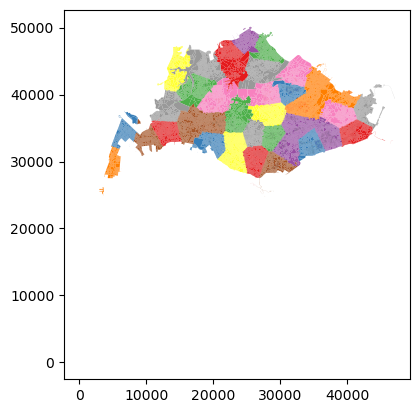

In [15]:
# Specify the column to use for color and colormap
column = 'cluster'
cmap = 'Set1'

# Plot the GeoDataFrame with colors determined by the 'cluster' column
tessellation.plot(column=column, cmap=cmap)

In [16]:
duplicates(tessellation)

0

In [17]:
# Assume `gdf` is a GeoDataFrame
tessellation_grouped = tessellation.groupby('cluster')

# Create a dictionary of separate GeoDataFrames, one for each group
tessellation_separate = dict()
for group_name, group in tessellation_grouped:
    tessellation_separate[group_name] = group

In [18]:
dask_tessellation = dgpd.from_geopandas(tessellation, npartitions=16)

dask_tessellation = dask_tessellation.dissolve(by='cluster')

cluster = dask_tessellation.compute()

<Axes: >

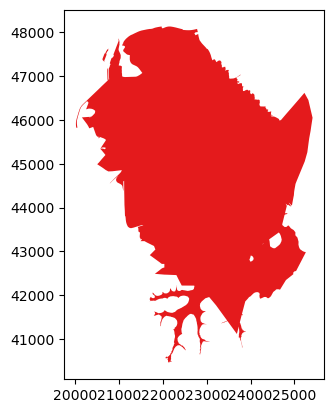

In [65]:

# Specify the column to use for color and colormap
column = 'cluster'
cmap = 'Set1'

# Plot the GeoDataFrame with colors determined by the 'cluster' column
cluster.loc[[2]].plot(cmap=cmap)

In [66]:
Daskcluster.close()
client.shutdown()

2023-03-22 23:36:30,291 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/worker.py", line 1238, in heartbeat
    response = await retry_operation(
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/utils_comm.py", line 413, in retry
    return await coro()
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/core.py", line 1234, in send_recv_from_rpc


In [67]:
cluster.to_parquet("./out/singapore/clusters.pq")

In [68]:
file_pattern = "./out/singapore/tess_chunk_*.pq"
file_list = glob.glob(file_pattern)

for file_path in file_list:
    os.remove(file_path)

for key in tessellation_separate:
    out = tessellation_separate[key]
    print(duplicates(out))
    print(out)
    out.to_parquet("./out/singapore/tess_chunk_"+str(key)+".pq")

0
              uID                                           geometry    eID  \
140         143.0  POLYGON ((27335.851 32063.268, 27335.485 32063...   1225   
141         144.0  POLYGON ((26497.254 31912.886, 26496.992 31914...   1222   
145         148.0  POLYGON ((24769.389 30034.394, 24770.992 30037...   1251   
149         152.0  POLYGON ((27417.983 31919.866, 27422.035 31922...     79   
150         153.0  POLYGON ((27212.986 32062.921, 27214.871 32061...   1225   
...           ...                                                ...    ...   
116238  5011262.0  POLYGON ((27182.251 30521.715, 27172.518 30520...  14763   
116239  5011263.0  POLYGON ((27171.527 30520.303, 27172.518 30520...  14764   
116240  5011264.0  POLYGON ((27184.007 30543.610, 27172.048 30541...  14765   
116322  5011346.0  POLYGON ((26881.562 30469.431, 26502.599 30508...  14870   
116323  5011347.0  POLYGON ((26383.486 30520.888, 26392.554 30520...  14871   

        cluster  
140           0  
141          

In [69]:
includes_dict = dict()
for i in range(n_clusters):
    includes_dict[i] = []

for index, row in tqdm(tessellation.iterrows(), total=tessellation.shape[0]):
    includes_dict[row["cluster"]].append(row["uID"])

with open('./out/singapore/clustertess.json', 'w') as f:
    json.dump(includes_dict, f)

  0%|          | 0/116389 [00:00<?, ?it/s]